This notebook aims at introducing the framework considered for the Pytorch based optimisation.

Author: Francesco Capuano, S17 Summer 2022 Intern @ ELI beamlines, Prague.

# Motivation
Gradient-Free optimisation is a must-go in lots of areas in which it appears as the sole option, everyone seem to like it because of the very intuitive nature of some of the algorithms employed.

However, **it is generally sub-optimal**, both for what concerns convergence speed and quality of the found solutions. 

To sum up: black-box optimisation is really well performing when only access to $f$ is given, even if (when feasible) using $\nabla f$ (or, if possible $\nabla^2 f$) typically grants result of improved quality.

In this notebook, a python framework which supports great GPU-integration and **auto-differentiation** is used to demonstrate that, while certainly expensive in terms of knowledge and time, comprehension of the objective can be used to improve algorithms. The framework adopted is **Pytorch**. 

# Objective Function

In this notebook I will explore the optimisation of the $\mathbb R^2$-Ackley function, a particularly nasty non-linear non-convex function which is often used as a benchmark for optimisation algorithms. The function is then: 

$$
f(\boldsymbol{x}) = -a \cdot \exp \bigg( -b \cdot \sqrt{\frac{1}{d} \sum_{i=1}^d x_i^2} \bigg) - exp \bigg( \frac 1d \sum_{i=1}^{d} \cos (cx_i) \bigg) + a + \exp(1)
$$

In this notebook the function's parameters are: 

1. $a = 20$

2. $b = 0.2$

3. $c = 2\pi$

4. $d = 2$

Which translates to the following `ackley` function (implemented using PyTorch API).

In [1]:
import torch

def ackley_2input(x1:torch.tensor, x2:torch.tensor) -> torch.tensor: 
    r"""
    This function implements the 2D-Ackley function using pytorch tensors with a=20, b=0.2, c=2*\pi
    """
    a, b, c, d = 20, 0.2, 2 * torch.pi, 2
    
    first_part = -a * torch.exp(-b * torch.sqrt((1/d) * (x1**2 + x2**2)))
    second_part = -torch.exp((1/d) * (torch.cos(c * x1) + torch.cos(c * x2)))
    return first_part + second_part + a + torch.exp(torch.tensor(1))

This function can be even be visualized with the following snippet

/Users/francescocapuano/opt/anaconda3/envs/elienv/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


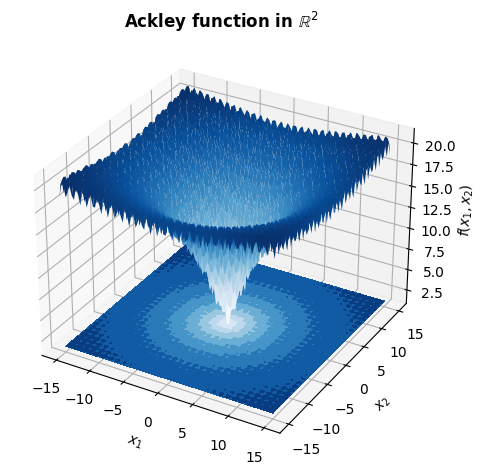

In [2]:
import matplotlib.pyplot as plt
import numpy as np
range_ = 15
x1, x2 = torch.linspace(-range_, +range_, steps = 100), torch.linspace(-range_, +range_, steps = 100)
X1, X2 = torch.meshgrid(x1, x2)
Z = ackley_2input(X1, X2)

my_map = "Blues"

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.set_xlabel(r"$x_1$"); ax.set_ylabel(r"$x_2$"); ax.set_zlabel(r"$f(x_1, x_2)$")

surf = ax.plot_surface(X1.numpy(), X2.numpy(), Z.numpy(), cmap = my_map)

cset = ax.contourf(X1.numpy(), X2.numpy(), Z.numpy(),
                   zdir ='z',
                   offset = np.min(Z.numpy()),
                   cmap = my_map)

ax.set_title(r"Ackley function in $\mathbb{R}^2$", fontweight = "bold")
fig.tight_layout()
plt.show()

Clearly enough not only this function is not convex, but it is not even an easy function to approximate when starting away from the global minimum, in $\mathbb R^2$ coincident with the space origin. 

The pytorch implementation grants the afore mentioned possibility of using differential information to carry out optimisation (in this case, mimimisation).
All it is necessary, is to carry out an evaluation of the objective function giving as input tensors which do store gradient information. Once again, in Pytorch this is a piece of cake.

In [3]:
x = (10 * torch.ones(2)).requires_grad_(True)

`x` now *can* store gradient information, but the gradient $\frac{\partial f}{\partial x}$ is not stored as long as a *backward* pass of $f$ is performed. This backward pass is what enables the unrolling of the computational graph and the **exact** computation of the gradient considered.

In [4]:
f_obj = ackley_2input(*x)
f_obj.backward()
print(x.grad)

tensor([0.2707, 0.2707])


Now `x` stores gradient information. Great. To visualize this information it is possible to re-elaborate the afore presented plot. 

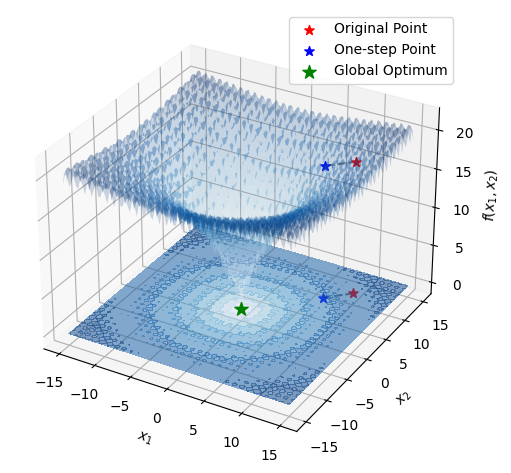

In [5]:
x1, x2, z = X1.numpy(), X2.numpy(), Z.numpy()
lr = 10

fig = plt.figure(1)
ax = plt.axes(projection='3d')

my_map = "Blues"

ax.set_xlabel(r"$x_1$"); ax.set_ylabel(r"$x_2$"); ax.set_zlabel(r"$f(x_1, x_2)$")

surf = ax.plot_surface(x1, x2, z, cmap = my_map, alpha = .2)

cset = ax.contourf(x1, x2, z,
                   offset = 0,
                   alpha = 0.5, 
                   cmap = my_map)

ax.scatter(*x.detach().numpy(),
           zs = ackley_2input(*x).detach().numpy(),
           marker = "*",
           c = "red",
           s = 50,
           label = "Original Point")

ax.scatter(*(x.detach().numpy() - lr * x.grad.numpy()),
           zs = ackley_2input(*(x - lr*x.grad)).detach().numpy(),
           marker = "*",
           c = "blue",
           s = 50,
           label = "One-step Point")

ax.plot(xs = [x[0].detach().numpy(), x[0].detach().numpy() - lr * x.grad[0].numpy()], 
        ys = [x[1].detach().numpy(), x[1].detach().numpy() - lr * x.grad[1].numpy()],
        zs = [ackley_2input(*x).detach().numpy(), ackley_2input(*(x - lr * x.grad)).detach().numpy()], 
        ls = "--",
        color = "grey")

ax.scatter(*x.detach().numpy(),
           marker = "*",
           c = "red",
           s = 50)

ax.plot(xs = [x[0].detach().numpy(), x[0].detach().numpy() - lr * x.grad[0].numpy()], 
        ys = [x[1].detach().numpy(), x[1].detach().numpy() - lr * x.grad[1].numpy()], 
        ls = "--",
        color = "grey")

ax.scatter(*(x.detach().numpy() - lr * x.grad.numpy()),
           marker = "*",
           c = "blue",
           s = 50)

ax.scatter(xs = 0,
           ys = 0,
           zs = ackley_2input(*torch.zeros(2)),
           marker = "*",
           c = "green",
           s = 100,
           label = "Global Optimum")

ax.legend()
fig.tight_layout()
plt.show()

From here on, the focus will mainly be to design an optimisation algorithm that, harnessing pytorch autograd power, can optimize the function using **differential information**. 

In [6]:
# slightly more general ackley implementation
def ackley(x:torch.tensor) -> torch.tensor: 
    r"""
    This function implements the 2D-Ackley function using pytorch tensors with a=20, b=0.2, c=2*\pi
    """
    a, b, c, d = 20, 0.2, 2 * torch.pi, len(x)
    
    first_part = -a * torch.exp(-b * torch.sqrt((1/d) * (x**2).sum()))
    second_part = -torch.exp((1/d) * torch.cos(c*x).sum())
    return first_part + second_part + a + torch.exp(torch.tensor(1))

In [7]:
import torch
from typing import Tuple
from tqdm import tqdm
from torch.linalg import norm, solve
from torch.autograd.functional import hessian

def adagrad(
    f,
    x:torch.tensor,
    eta_0:float=1.,
    maxit:int=int(1e2),
    tolgrad:float=1e-6,
    eps:float=1e-6)->Tuple[torch.tensor, torch.tensor]:
    
    """
    This function performs the ADAGRAD optimisation algorithm.
    """
    k = 0
    xk = x
    # giving gradient to xk
    f(xk).backward()
    
    points = torch.zeros(size = (maxit, len(x)))
    grads = torch.zeros(maxit)
    
    grad_k = xk.grad
    
    sum_grad_squared = grad_k ** 2
    lr = eta_0 / torch.sqrt(eps + sum_grad_squared)
    
    for k in (pbar := tqdm(range(maxit))): 
        # store & display information
        points[k, :] = xk.detach()
        grads[k] = norm(grad_k)
        pbar.set_description("It. {} - Norm Grad {:4e}".format(k+1, norm(grad_k)))
        # update position      
        xk = (xk - lr * grad_k).detach().requires_grad_(True)
        # compute gradient at new position
        f(xk).backward()
        grad_k = xk.grad
        # adapt learning rate
        sum_grad_squared += grad_k ** 2
        lr = eta_0 / torch.sqrt(eps + sum_grad_squared)
        # reiterate (if not converged)
        if norm(grad_k) <= tolgrad: 
            points = points[:, :k]
            grads = grads[:k]
            break
        else: 
            k += 1
            continue
            
    return points.detach(), grads

def newton(
    f,
    x:torch.tensor,
    maxit:int=int(1e2),
    tolgrad:float=1e-6,
    eps:float=1e-6, 
    disable_tqdm:bool=False)->Tuple[torch.tensor, torch.tensor]:
    
    """
    This function implements the NEWTON optimisation algorithm.
    """
    k = 0
    alpha_k = 1
    xk = x
    # giving gradient to xk
    f(xk).backward()
    # storing the hessian of f(xk)
    hess_k = hessian(f, xk)
    # initializations
    points = torch.zeros(size = (maxit, len(x)))
    grads = torch.zeros(maxit)
    # first gradient
    grad_k = xk.grad
    for k in (pbar := tqdm(range(maxit), disable = disable_tqdm)): 
        # compute newton direction
        pk = solve(hess_k, -grad_k)
        # update position
        xk = (xk + alpha_k * pk).detach().requires_grad_(True)
        # compute gradient at new position
        f(xk).backward()
        grad_k = xk.grad
        # computing the hessian of f(xk)
        hess_k = hessian(f, xk)
        # store & display information
        points[k, :] = xk.detach()
        grads[k] = norm(grad_k)
        pbar.set_description("It. {} - Norm Grad {:4e}".format(k+1, norm(grad_k)))
        # reiterate (if not converged)
        if norm(grad_k) <= tolgrad: 
            points = points[:, :k]
            grads = grads[:k]
            break
        else: 
            k += 1
            continue   
    return points.detach(), grads
# ackley specific
def plot_route(
    points:torch.tensor) -> None: 
    """This function plots the route followed by the optimizers. 
    """
    x1 = torch.linspace(points[:,0].min(), points[:,0].max(), steps = 50)
    x2 = torch.linspace(points[:,1].min(), points[:,1].max(), steps = 50)

    X1, X2 = torch.meshgrid(x1, x2)
    Z = ackley_2input(X1, X2)
    x1, x2, z = X1.numpy(), X2.numpy(), Z.numpy()

    fig = plt.figure(2)
    # rigth subplot
    ax1 = fig.add_subplot(1, 2, 2, projection='3d')
    ax = ax1
    my_map = "Blues"

    ax.set_xlabel(r"$x_1$"); ax.set_ylabel(r"$x_2$"); ax.set_zlabel(r"$f(x_1, x_2)$")

    surf = ax.plot_surface(x1, x2, z, cmap = my_map, alpha = .55)

    ax.scatter(xs = points[:, 0],
               ys = points[:, 1],
               zs = [ackley(p).item() for p in points],
               c = [ackley(p) for p in points],
               marker = "*",
               s = 20, 
               label = "Optimization Route")

    ax.scatter(xs = points[0, 0],
               ys = points[0, 1], 
               zs = ackley(points[0, :]), 
               marker = "o", 
               s = 25, 
               label = "Start Point", 
               color = "blue")

    ax.scatter(xs = points[-1, 0],
               ys = points[-1, 1], 
               zs = ackley(points[-1, :]), 
               marker = "o", 
               s = 25, 
               label = "End Point", 
               color = "orange")

    ax.legend()
    # left subplot
    ax2 = fig.add_subplot(1,2,1); ax = ax2

    ax.set_xlabel(r"$x_1$"); ax.set_ylabel(r"$x_2$");

    cset = ax.contourf(x1, x2, z,
                       alpha = 0.85, 
                       cmap = "Blues"
                      )

    ax.scatter(x = points[:, 0],
               y = points[:, 1], 
               c = [ackley(p) for p in points],
               marker = "*",
               s = 20, 
               cmap = my_map,
               label = "Optimization Route")

    ax.scatter(x = points[0, 0],
               y = points[0, 1], 
               marker = "o", 
               s = 50, 
               label = "Start Point", 
               color = "orange")

    ax.scatter(x = points[-1, 0],
               y = points[-1, 1],     
               marker = "o", 
               s = 50, 
               label = "End Point", 
               color = "red")

    ax.legend()
    fig.suptitle("Optimisation Route", fontweight = "bold")

    fig.tight_layout()

In [8]:
# optimizing using the Adagrad algorithm
points_adagrad, grads_adagrad = adagrad(ackley, x, eta_0 = 5, maxit = 1000)
points_newton, grads_newton = newton(ackley, x, maxit = 1000)

It. 1000 - Norm Grad 2.448732e-05: 100%|███| 1000/1000 [00:04<00:00, 215.03it/s]


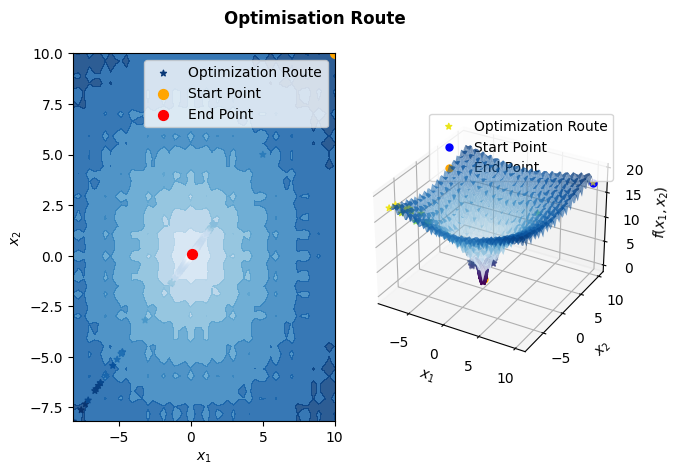

In [9]:
plot_route(points_adagrad)

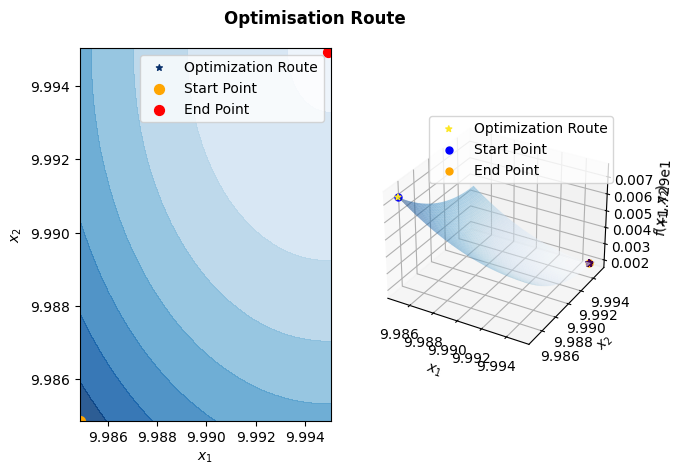

In [10]:
plot_route(points_newton)

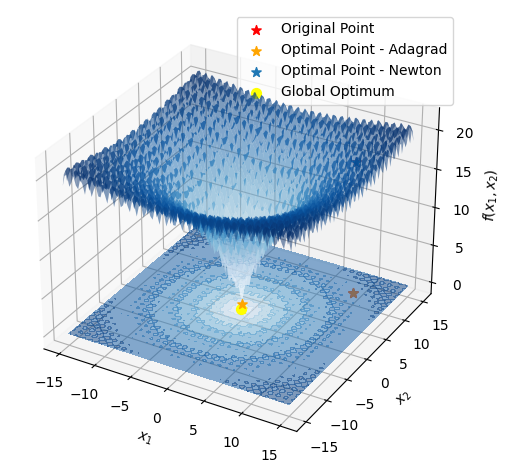

In [11]:
x1, x2, z = X1.numpy(), X2.numpy(), Z.numpy()

fig = plt.figure(1)
ax = plt.axes(projection='3d')

my_map = "Blues"

ax.set_xlabel(r"$x_1$"); ax.set_ylabel(r"$x_2$"); ax.set_zlabel(r"$f(x_1, x_2)$")

surf = ax.plot_surface(x1, x2, z, cmap = my_map, alpha = 0.5)

cset = ax.contourf(x1, x2, z,
                   offset = 0,
                   alpha = 0.5, 
                   cmap = my_map)

ax.scatter(*x.detach().numpy(),
           zs = ackley_2input(*x).detach().numpy(),
           marker = "*",
           c = "red",
           s = 50,
           label = "Original Point")

ax.scatter(*points_adagrad[-1].numpy(),
           zs = ackley_2input(*points_adagrad[-1]).detach().numpy(),
           marker = "*",
           s = 50,
           c = "orange",
           label = "Optimal Point - Adagrad")

ax.scatter(*points_newton[-1].numpy(),
           zs = ackley_2input(*points_newton[-1]).detach().numpy(),
           marker = "*",
           s = 50,
           label = "Optimal Point - Newton")

ax.scatter(*x.detach().numpy(),
           zs = 0,
           marker = "*",
           c = "red",
           s = 50)

ax.scatter(*points_adagrad[-1].numpy(),
           zs = 0,
           marker = "*",
           c = "orange",
           s = 50)

ax.scatter(*points_newton[-1].numpy(),
           zs = 0,
           marker = "*",
           s = 50)

ax.scatter(xs = 0,
           ys = 0,
           zs = ackley_2input(*torch.zeros(2)),
           marker = "o",
           c = "yellow",
           s = 50,
           label = "Global Optimum")

ax.legend()
fig.tight_layout()
plt.show()

As it is possible to see, the ADAGRAD algorithm, in the 1000 its which are set to let it run converges to a pretty good point with respect to the Global Optimum position. 
On the other hand, the absence of momentum of the Newton method does not allow to obtain convergence to nothing but a local minimum (which is also really near to the starting point). 

Now, this function is particularly difficult to globally optmise using the Newton Method because of the presence of a large number of local minima. However, Newton Method could still be used when other methods are reaching a region of the space in which the evolution of the optimisation route appears to be erratic, as the absence of information on the objective function's curvature severly affects convergence's speed. In particular this is very much more likely considering the evolution of the optimisation route in 2D. 

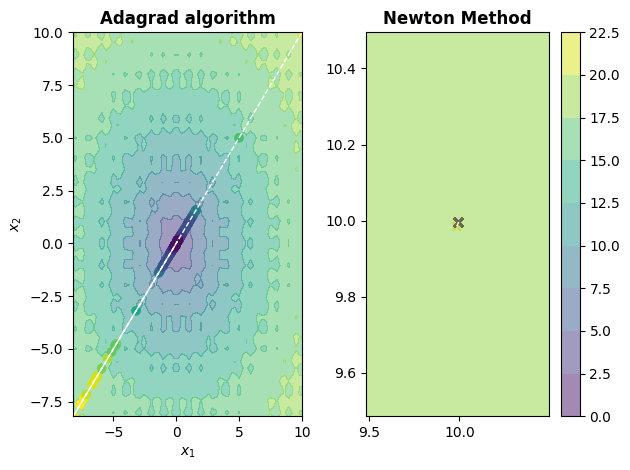

In [12]:
x1, x2, z = X1.numpy(), X2.numpy(), Z.numpy()

fig, axs = plt.subplots(nrows = 1, ncols = 2)
freq = 10

my_map = "viridis"

ax = axs[0]
cset = ax.contourf(x1, x2, z, cmap = my_map, alpha = 0.5)
ax.set_xlabel(r"$x_1$"); ax.set_ylabel(r"$x_2$");
ax.scatter(
    x = points_adagrad[:, 0],
    y = points_adagrad[:, 1],
    c = list(map(ackley, points_adagrad)),
    marker = "o",
    cmap = my_map)
ax.set_title("Adagrad algorithm", fontsize = 12, fontweight = "bold")
ax.plot(points_adagrad[:, 0], points_adagrad[:, 1], color = "white", lw = 1, ls = "--", label = "AdaGrad")

ax.set_xlim(points_adagrad[:,0].min(), points_adagrad[:,0].max())
ax.set_ylim(points_adagrad[:,1].min(), points_adagrad[:,1].max())

ax = axs[1]
ax.scatter(
    x = points_newton[:, 0],
    y = points_newton[:, 1],
    c = list(map(ackley, points_newton)),
    marker = "x",
    cmap = my_map)

ax.plot(points_newton[:, 0], points_newton[:, 1], color = "white", lw = 1, ls = "--", label = "Newton")

cset = ax.contourf(x1, x2, z, cmap = my_map, alpha = 0.5)

ax.set_xlim(0.95 * points_newton[:,0].min(), 1.05 * points_newton[:,0].max())
ax.set_ylim(0.95 * points_newton[:,1].min(), 1.05 * points_newton[:,1].max())
ax.set_title("Newton Method", fontsize = 12, fontweight = "bold")
fig.colorbar(cset)
fig.tight_layout()

Is possible to see that Newton Method is really well suited to **identify optimal points in a very limited number of iterations**. 

However, this fact itself "constraints" the method to converge to a local optimum only, whereas **Adagrad is clearly able to skip the various local optima** and speed up to a good region, even if the route ends up heavily oscillating around the optimal point. This phenomenon is due to overshooting, which is a problem **Newton method does not suffer from**. 

Consider now the case in which not only the objective function must be minimized but it also has to be minimized with respect to some predefined constraints, such as **box-constraints** which do force the variables to be inside of a predefined region. While the presence of constraints essentially transforms the very nature of the problem, it is still possible to use the methods typical of **unconstrained-optimisation** if some adjustments are made to the objective function. 

In particular, 

$$
\begin{aligned}
\min f(\boldsymbol x) \\
\text{s.t. } \boldsymbol{x} \in \mathcal X
\end{aligned}
$$

Can clearly enough be revisited into its unconstrained version equal to: 

$$
\begin{aligned}
\min f(\boldsymbol x) + \frac 1\varepsilon p(\boldsymbol x; \mathcal X)
\end{aligned}
$$

With $\varepsilon \in \mathbb R^+$ and $p(\boldsymbol x; \mathcal X)$ a function satisfying the following conditions: 

1. $P$ is a continuously differentiable (i.e. is "smooth")


2. $p(\boldsymbol x; \mathcal X) \big \vert_{\boldsymbol x \in \mathcal X} = 0$ (no penalty inside the feasible region $\mathcal X$). 


3. $p(\boldsymbol x; \mathcal X) \big \vert_{\boldsymbol x \notin \mathcal X} > 0$ (penalty only outside of the feasible region $\mathcal X$).

While different are the penalty functions which can be considered, it is possible to have a better understanding of the choice first considering the type of constraints. Let $f$ be the Ackley function previously considered. One might have a situation for which: 

$$
\mathcal X := \{\boldsymbol x \in \mathbb R^2 \vert x_1 \in I_1 = [-1, 3] \cap x_2 \in I_2 = [-3, 1] \}
$$

In this case, the initial constrained problem can be expressed as: 

$$
\begin{equation}
\begin{aligned}
\min f(\boldsymbol x) \\
\text{s.t. } -1 \leq x_1 \leq 3 \\
-3 \leq x_2 \leq 1
\end{aligned}
\label{pr:const_prob}\tag{1}
\end{equation}
$$

Which can be reformulated, exploding the inequality constraints, as: 
$$
\begin{aligned}
\min f(\boldsymbol x) \\
x_1 \leq 3 \Longleftrightarrow x_1 - 3 \leq 0 \\
-x_1 \leq 1 \Longleftrightarrow - x_1 - 1 \leq 0 \\
x_2 \leq 1 \Longleftrightarrow x_2 - 1 \leq 0 \\
-x_2 \leq 3 \Longleftrightarrow -x_2 - 3 \leq 0 \\
\end{aligned}
$$

This type of problems can be tackled using a **square penalty function**, i.e. a function $p$ defined as: 

$$
p(\boldsymbol x; \mathcal X) = \sum_{i=1}^{m = dim(\boldsymbol x)} \big(\max\{0, g_i(x)\}\big)^2
$$

Considering this, constrained problem [$\ref{pr:const_prob}$] can be converted to its unconstrained version corresponding to: 

$$
\begin{aligned}
\min_{\boldsymbol x} f(\boldsymbol x) + \frac 1\varepsilon \sum_{i=1}^{m = dim(\boldsymbol x)} \big(\max\{0, g_i(x)\}\big)^2
\end{aligned}
$$

Moreover, it is possible to prove that for certain (not all) values of $\varepsilon \to 0$ the solution of the unconstrained-penalized problem approaches the solution of its unconstrained version. 

The very definition of the new problem calls for a new method to solve the problem at hand. This new method is actually nothing but any algorithm in which the penalty term $\varepsilon$ is adjusted accordingly so to obtain the following behaviour: 

1. At the beginning of the iterations, the route should approach a region of a good quality almost *regardless* from the constraint, so the **penalty term should be actually large**

2. As the quality of the found solutions become better and better, the **penalty term should start to decrease** as it starts to be fundamental that the region which has been found as promising is also feasible to declare convergence.

In [13]:
class PenalizedFunction: 
    def __init__(self, f, bounds:torch.tensor, penalty_term:torch.tensor):
        """Init function takes only penalty term (to be updated during optimisation) and bounds.
        """
        self.f = f
        self.bounds = bounds
        self.epsilon = penalty_term
    
    def evaluate(self, x:torch.tensor) -> torch.tensor: 
        """
        This function returns the penalized version of the objective function considering input bounds. 
        """
        # minus(lb)-plud(ub) the input array
        pm_input = torch.hstack(list(map(lambda component: torch.stack((-component, component)), x)))
        # reshaping so as to have lower bound/upper bound/lower bound/...
        bounds = self.bounds.reshape(-1)
        # multiplying so as to have +lower bound/-upper bound/+lower bound/ ...
        multipliers = torch.empty_like(bounds)
        multipliers[::2] = 1; multipliers[1::2] = -1
        bounds = bounds * multipliers
        # summing component-wise input and corresponding bound to obtain square violation
        violations = torch.max(torch.zeros_like(bounds), pm_input + bounds) ** 2
        return self.f(x) + (1/self.epsilon) * violations.sum()
    
    def evaluate_root(self, x:torch.tensor) -> torch.tensor: 
        """
        This function returns the penalized version of the objective function considering input bounds. 
        """
        # minus(lb)-plud(ub) the input array
        pm_input = torch.hstack(list(map(lambda component: torch.stack((-component, component)), x)))
        # reshaping so as to have lower bound/upper bound/lower bound/...
        bounds = self.bounds.reshape(-1)
        # multiplying so as to have +lower bound/-upper bound/+lower bound/ ...
        multipliers = torch.empty_like(bounds)
        multipliers[::2] = 1; multipliers[1::2] = -1
        bounds = bounds * multipliers
        # summing component-wise input and corresponding bound to obtain violation
        violations = torch.max(torch.zeros_like(bounds), pm_input + bounds)
        return self.f(x) + (1/self.epsilon) * violations.sum()
    
    
    def optimize(self, 
                 x0:torch.tensor, 
                 maxit:int=int(1e3), 
                 tolgrad:float=1e-6, 
                 eta_0:float=1,
                 eps:float=1e-3,
                 square:bool=True) -> Tuple[torch.tensor, torch.tensor]: 
        """
        This function optimises the unconstrained (penalized) objective function
        """
        # the objective function is the penalized one 
        f = self.evaluate if square else self.evaluate_root
        k = 0
        xk = x0.requires_grad_(True)
        # giving gradient to xk
        f(xk).backward()

        points = torch.zeros(size = (maxit, len(x)))
        grads = torch.zeros(maxit)

        grad_k = xk.grad

        sum_grad_squared = grad_k ** 2
        lr = eta_0 / torch.sqrt(eps + sum_grad_squared)

        for k in (pbar := tqdm(range(maxit))): 
            # store & display information
            points[k, :] = xk.detach()
            grads[k] = norm(grad_k)
            pbar.set_description("It. {} - Norm Grad {:4e}".format(k+1, norm(grad_k)))
            # update position      
            xk = (xk - lr * grad_k).detach().requires_grad_(True)
            # compute gradient at new position
            f(xk).backward()
            grad_k = xk.grad
            # adapt learning rate
            sum_grad_squared += grad_k ** 2
            lr = eta_0 / torch.sqrt(eps + sum_grad_squared)
            # reiterate (if not converged)
            if norm(grad_k) <= tolgrad: 
                points = points[:, :k]
                grads = grads[:k]
                break
            else: 
                k += 1
                # increasing the penalty as iterate progress
                self.epsilon *= .99
                continue

        return points.detach(), grads

In [14]:
pf = PenalizedFunction(
    f = ackley,
    bounds = torch.tensor([-1, 3, -3, 1]).reshape(2, 2),
    penalty_term = torch.tensor(1.)
)
points_penalized, grads_penalized = pf.optimize(x, eta_0 = .1)

It. 1000 - Norm Grad 1.054195e+00: 100%|███| 1000/1000 [00:03<00:00, 271.71it/s]


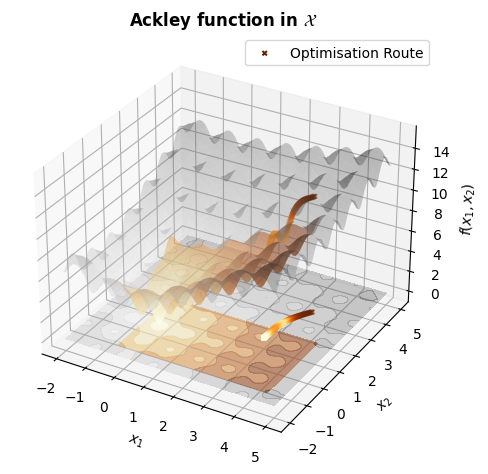

In [15]:
x1 = torch.linspace(-2, 5, steps = 100)
x2 = torch.linspace(-2, 5, steps = 100)

feasible_x1 = torch.linspace(0.5*pf.bounds[0,0], 1.5*pf.bounds[0,1], steps = 100)
feasible_x2 = torch.linspace(0.5*pf.bounds[1,0], 1.5*pf.bounds[1,1], steps = 100)

X1, X2 = torch.meshgrid(x1, x2)
feasible_X1, feasible_X2 = torch.meshgrid(feasible_x1, feasible_x2)

points_penalized_plot = points_penalized[-500:]

Z = ackley_2input(X1, X2)
feasible_Z = ackley_2input(feasible_X1, feasible_X2)

my_map = "Greys"
feasible_map = "YlOrBr"

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.set_xlabel(r"$x_1$"); ax.set_ylabel(r"$x_2$"); ax.set_zlabel(r"$f(x_1, x_2)$")

surf = ax.plot_surface(X1.numpy(), X2.numpy(), Z.numpy(), cmap = my_map, alpha = .25)
cset = ax.contourf(X1.numpy(), X2.numpy(), Z.numpy(),
                   zdir ='z',
                   offset = np.min(Z.numpy()),
                   cmap = my_map, alpha = .25)

feasible_surf = ax.plot_surface(
    feasible_X1.numpy(), 
    feasible_X2.numpy(), 
    feasible_Z.numpy(),
    cmap = feasible_map,
    alpha = .5)

feasible_cset = ax.contourf(feasible_X1.numpy(), feasible_X2.numpy(), feasible_Z.numpy(),
                   zdir ='z',
                   offset = np.min(feasible_Z.numpy()),
                   cmap = feasible_map, 
                   alpha = .5)

ax.scatter(
    points_penalized_plot[:,0],
    points_penalized_plot[:,1],
    marker = "x",
    s = 10,
    c = ackley_2input(points_penalized_plot[:,0], points_penalized_plot[:,1]),
    cmap = feasible_map)

ax.scatter(
    points_penalized_plot[:,0],
    points_penalized_plot[:,1],
    zs = ackley_2input(points_penalized_plot[:,0], points_penalized_plot[:,1]),
    marker = "x",
    s = 10,
    c = ackley_2input(points_penalized_plot[:,0], points_penalized_plot[:,1]),
    cmap = feasible_map,
    label = "Optimisation Route")

ax.set_title(r"Ackley function in $\mathcal{X}$", fontweight = "bold")
ax.legend()
fig.tight_layout()
plt.show()

Which shows that the considered method is still able to converge to a local optimum for the original problem while solving the unconstrained penalized-problem, adopting the solution considered. 

This concludes this study on how to apply the autograd-pytorch library to optimise $f$. 